In [1]:
conda activate bns


Note: you may need to restart the kernel to use updated packages.


In [54]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.stats import lognorm, norm
import os
import copy

from BNS_JT import cpm, variable
from BNS_JT.trans import get_arcs_length, get_all_paths_and_times
from BNS_JT.cpm import variable_elim, mcs_product, single_sample, get_sample_order
from BNS_JT.branch import get_cmat_from_branches, branch_and_bound


In [55]:
np.set_printoptions(precision=3)
HOME = os.getcwd()

# Network

This is a hypothetical network with arbitrary scales, epicentre location and road types.

{'e1': 20.09975124224178, 'e2': 18.741664813991314, 'e3': 20.0, 'e4': 18.527007313648905, 'e5': 18.527007313648905, 'e6': 17.11724276862369, 'e7': 17.0}
{('n1', 'n4'): [(['e1', 'e3', 'e5', 'e7', 'e6'], 0.2733333333333333), (['e1', 'e4', 'e6'], 0.16666666666666669), (['e2'], 0.06)], ('n1', 'n5'): [(['e1', 'e3', 'e5', 'e7'], 0.20666666666666667), (['e1', 'e4'], 0.1), (['e2', 'e6'], 0.12666666666666665)], ('n1', 'n6'): [(['e1', 'e3', 'e5'], 0.16666666666666666), (['e1', 'e4', 'e7'], 0.14), (['e2', 'e6', 'e4', 'e3', 'e5'], 0.3133333333333333), (['e2', 'e6', 'e7'], 0.16666666666666666)]}


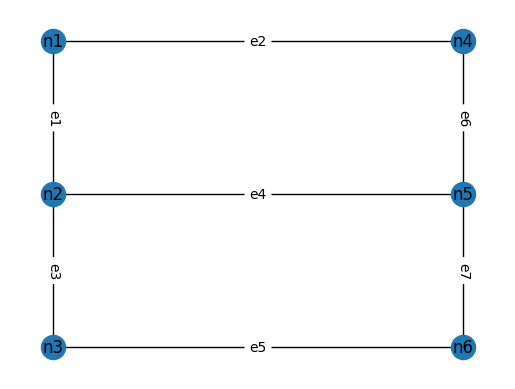

In [56]:
node_coords = {'n1': (0, 0),
               'n2': (0, -2),
               'n3': (0, -4),
               'n4': (3, 0),
               'n5': (3, -2),
               'n6': (3, -4)} # km

arcs = {'e1': ['n1', 'n2'],
        'e2': ['n1', 'n4'],
        'e3': ['n2', 'n3'],
        'e4': ['n2', 'n5'],
        'e5': ['n3', 'n6'],
        'e6': ['n4', 'n5'],
        'e7': ['n5', 'n6']}

# Fragility curves -- From HAZUS-EQ model (roads are regarded as disconnected when being extensively or completely damaged)

frag = {'major': {'med': 60.0, 'std': 0.7},
        'urban' : {'med': 24.0, 'std': 0.7},
        'bridge': {'med': 1.1, 'std': 3.9}}

arcs_type = {'e1': 'major',
             'e2': 'bridge',
             'e3': 'urban',
             'e4': 'bridge',
             'e5': 'major',
             'e6': 'urban',
             'e7': 'major'}

arcs_avg_kmh = {'e1': 50,
                'e2': 50,
                'e3': 30,
                'e4': 50,
                'e5': 50,
                'e6': 30,
                'e7': 50}

var_ODs = {'od1': ('n1', 'n4'),
           'od2': ('n1', 'n5'),
           'od3': ('n1', 'n6')}

nODs = len(var_ODs)

# Arcs' states index compatible with variable B index, and C
arc_surv = 1 - 1
arc_fail = 2 - 1
arc_either = 3 - 1

arc_lens_km = get_arcs_length(arcs, node_coords)

# Distance to epicentre (epicentre is assumed to have been observed.)
arcs_cloc_km = {}
for k, v in arcs.items():
    cloc = 0.5 * (np.array( node_coords[v[0]] ) + np.array( node_coords[v[1]] ))
    arcs_cloc_km[k] = cloc

epi_loc_km = (20, -3)
arcs_epi_dist_km = {}
for k, v in arcs_cloc_km.items():
    diff = np.array(v) - np.array(epi_loc_km)
    arcs_epi_dist_km[k] = np.sqrt(np.sum(diff**2))
print(arcs_epi_dist_km)

#arcTimes_h = arcLens_km ./ arcs_Vavg_kmh
arc_times_h = {k: v/arcs_avg_kmh[k] for k, v in arc_lens_km.items()}

# create a graph
G = nx.Graph()
for k, x in arcs.items():
    G.add_edge(x[0], x[1], time=arc_times_h[k], label=k)

for k, v in node_coords.items():
    G.add_node(k, pos=v)

path_time = get_all_paths_and_times(var_ODs.values(), G, key='time')
print( path_time )

# plot graph
pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'label')

fig = plt.figure()
ax = fig.add_subplot()
nx.draw(G, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
fig.savefig( os.path.join(HOME, 'graph_toy.png'), dpi=200)

# Add and sample hazard nodes.

We assume magnitude and epicentre are observed, and sample intensity measures (IMs) experienced by each component event. Note that such samples can be obtained by any approaches (e.g. ground motion prediction equations (GMPEs) or detailed simulation tools like Global Earthquake Model (GEM)). <br>
Here, we employ a GMPE proposed by Campbell (1997) for peak ground acceleration (PGA) and HAZUS EQ model for permanent ground displacement (PGD).

In [57]:
eq_m = 7 # observed

arcs_lpga_mean = {}
for k, v in arcs_epi_dist_km.items():
    lpga_mean = -3.512 + 0.904 * eq_m - 1.312 * np.log( np.sqrt( v**2 + (0.149 * np.exp(0.647*eq_m))**2 ) ) # Campbell (1997)
    arcs_lpga_mean[k] = lpga_mean
print( 'E[ log(A_H) ] for each arc (component):' )
print( {k: np.exp(v) for k,v in arcs_lpga_mean.items()} )

E[ log(A_H) ] for each arc (component):
{'e1': 0.2529664900800276, 'e2': 0.26886113914642845, 'e3': 0.2540890253419107, 'e4': 0.2714972127053331, 'e5': 0.2714972127053331, 'e6': 0.28968581274095156, 'e7': 0.2912683553162252}


We get the samples of PGA. Note that this is not an entirely correct application of Campbell (1997). Procedure is simplified to just to quickly get samples of IM.

In [58]:
no_samp = 10
no_arc = len(arcs)

cpms = {}
varbs = {}

C_pga = np.empty(shape=(no_samp, no_arc))
for i in range(no_arc):
    lpga_mean = arcs_lpga_mean['e'+str(i+1)]
    lpga_samps = np.random.normal( loc = lpga_mean, scale = 0.55, size = (no_samp,) )
    pga_samps = np.exp( lpga_samps )
    C_pga[:,i] = pga_samps
print(C_pga)


# TODO: Below does not work. CPM needs to be able to be defined over continuous or sampled variables.
#varbs['pga'] = variable.Variable(name='pga', B = [], values = [])
#p = np.empty(shape = (no_samp, 1))
#q = np.empty(shape = (no_samp, 1))
#cpms['pga'] = cpm.Cpm( variables = [varbs['pga']], no_child = no_arc, C = C_pga, p = p, q = q )
#print(varbs['pga'])
#print(cpms['pga'])


[[0.294 0.156 0.288 0.198 0.157 0.321 0.09 ]
 [0.161 0.273 0.178 0.311 1.717 0.671 0.215]
 [0.398 0.3   0.396 0.406 0.213 0.684 0.149]
 [0.305 0.299 0.188 0.62  0.108 0.464 0.11 ]
 [0.239 0.288 0.243 0.224 0.354 0.16  0.13 ]
 [0.122 0.394 0.079 0.226 0.439 0.312 0.143]
 [0.146 0.23  0.594 0.169 0.259 0.636 0.211]
 [0.119 0.171 0.227 0.302 0.145 0.591 0.241]
 [0.478 0.359 0.549 0.373 0.14  0.19  0.263]
 [0.245 0.33  0.23  0.378 0.623 0.289 0.204]]


Sample PGD. 

For PGD, which is the IM for paved roads, the causal mechanism is assumed as lateral spreading due to liquefaction (ref: HAZUS EQ model). <br>
Uncerty in PGD arises from PGA. For the moment, uncertainty in susceptibility category, and susceptibility category is assumed to be a single category (ref: Table 4-12 in HAZUS EQ model is ignored).

In [59]:
pga_c = 0.21 # (g) for Low

k_del = 0.0086 * eq_m**3 - 0.0914*eq_m**2 + 0.4698*eq_m - 0.9835

C_pgd = np.empty(shape=(no_samp, no_arc))
for i in range(no_arc):
    for j in range(no_samp):
        pga = C_pga[j,i]

        pga_rat = pga / pga_c
        if pga_rat < 1:
            pgd = 0
        elif pga_rat < 2:
            pgd = 12*pga_rat - 12 # inch
        elif pga_rat < 3:
            pgd = 18*pga_rat - 24
        else:
            pgd = 70*pga_rat - 180
        
        C_pgd[j,i] = k_del * pgd
        
print(C_pgd)


[[3.740e+00 0.000e+00 3.461e+00 0.000e+00 0.000e+00 4.916e+00 0.000e+00]
 [0.000e+00 2.816e+00 0.000e+00 4.496e+00 3.046e+02 3.391e+01 2.140e-01]
 [8.350e+00 3.973e+00 8.273e+00 8.696e+00 1.348e-01 3.722e+01 0.000e+00]
 [4.203e+00 3.967e+00 0.000e+00 2.260e+01 0.000e+00 1.224e+01 0.000e+00]
 [1.286e+00 3.470e+00 1.446e+00 6.204e-01 6.372e+00 0.000e+00 0.000e+00]
 [0.000e+00 8.184e+00 0.000e+00 6.943e-01 1.057e+01 4.518e+00 0.000e+00]
 [0.000e+00 8.679e-01 2.088e+01 0.000e+00 2.188e+00 2.485e+01 5.943e-02]
 [0.000e+00 0.000e+00 7.744e-01 4.102e+00 0.000e+00 2.071e+01 1.358e+00]
 [1.317e+01 6.626e+00 1.787e+01 7.216e+00 0.000e+00 0.000e+00 2.340e+00]
 [1.557e+00 5.334e+00 8.680e-01 7.452e+00 2.282e+01 3.503e+00 0.000e+00]]


Now we assume that we observed PGA at e2 and e5 by 0.2g and 0.3g respectively. We also assume that there is 10% of observation error. <br>
This updates sample weights by $f(oa_2 | a_2) \cdot f(oa_5 | a_5)$.

In [60]:
q = np.ones(shape=(no_samp,1)) # sample weight vector

for j in range(no_samp):
    q_j = norm.pdf( 0.2, C_pga[j, 2], scale = 0.2*0.1 ) * norm.pdf( 0.3, C_pga[j, 5], scale = 0.3*0.1 )
    q[j] = q_j
    
print(q)

[[1.294e-002]
 [8.849e-032]
 [8.302e-055]
 [7.266e-005]
 [4.963e-004]
 [2.630e-006]
 [9.812e-110]
 [3.517e-019]
 [3.602e-067]
 [8.314e+001]]


# Now component and system events.

First, we compute P(X_n=fail | sample_j).

In [61]:
arcs_pf = {}

for i in range(no_arc):
    k = 'e' + str(i+1)
    pf = np.zeros(shape=(no_samp,1))
    
    for j in range(no_samp):
        _type = arcs_type[k]
        if _type == 'bridge':
            prob = lognorm.cdf(C_pga[j,i], frag[_type]['std'], scale=frag[_type]['med'])
        else:
            prob = lognorm.cdf(C_pgd[j,i], frag[_type]['std'], scale=frag[_type]['med'])
        pf[j] = prob
        
    arcs_pf[k] = pf

    
print(arcs_pf['e2'])


[[0.308]
 [0.361]
 [0.369]
 [0.369]
 [0.366]
 [0.396]
 [0.344]
 [0.316]
 [0.387]
 [0.379]]


Quantify system (functionality) events.

In [62]:
lower = {x: 0 for x in arcs}  # Fail
upper = {x: 1 for x in arcs}  # surv
arc_condn = 1

i = 0 # System event index
k = 'od' + str(i+1)
state = 0
path_time_idx = [([], np.inf, state)]
for p in path_time[var_ODs[k]]:
    state += 1
    path_time_idx.append( p + tuple([state]) )

sb = branch_and_bound(path_time_idx, lower, upper, arc_condn)

variables = {}
B = np.array([[1, 0], [0, 1], [1, 1]])
for i in range(1, 8):
    variables[f'e{i}'] = variable.Variable(name=f'e{i}', B=B, values=['Fail', 'Surv'])
Cmat = get_cmat_from_branches(sb, variables)
print(Cmat)

b*: 1, sb: 1
b*: 5, sb: 6
b*: 4, sb: 6
b*: 5, sb: 6
b*: 4, sb: 6
b*: 3, sb: 5
b*: 4, sb: 5
b*: 3, sb: 5
b*: 2, sb: 4
b*: 3, sb: 4
b*: 2, sb: 4
b*: 1, sb: 3
[[1 1 2 1 2 1 1 1]
 [0 1 0 1 2 1 0 1]
 [3 1 1 1 2 1 0 1]
 [2 1 2 1 1 1 1 0]
 [0 1 0 1 1 1 0 0]
 [3 1 1 1 1 1 0 0]
 [0 1 0 1 0 1 2 0]
 [3 1 1 1 0 1 2 0]
 [2 1 2 1 1 0 1 2]
 [0 1 0 1 1 0 0 2]
 [3 1 1 1 1 0 0 2]
 [0 1 0 1 0 0 2 2]
 [3 1 1 1 0 0 2 2]
 [2 1 2 0 1 2 1 2]
 [0 1 0 0 1 2 0 2]
 [3 1 1 0 1 2 0 2]
 [0 1 0 0 0 2 2 2]
 [3 1 1 0 0 2 2 2]
 [0 0 0 2 2 2 2 2]
 [3 0 1 2 2 2 2 2]]


Calculate a probability vector correponding to Cmat.

In [63]:
no_c = len(Cmat)
p = np.ones(shape = (no_c, no_samp))

for i in range(no_arc):
    k = f'e{i+1}'
    pf_i = arcs_pf[k]
    
    for j in range(no_samp):

        for k in range(no_c):
            C_ik = Cmat[k,i+1]
            if C_ik == 0:
                prob_ijk = pf_i[j]
            elif C_ik == 1:
                prob_ijk = 1 - pf_i[j]
            else:
                prob_ijk = 1

            p[k,j] *= prob_ijk
    
print(p)

[[9.854e-01 3.153e-03 2.478e-01 8.318e-01 9.993e-01 9.850e-01 2.779e-01
  5.834e-01 6.532e-01 9.136e-01]
 [3.612e-03 2.521e-03 2.533e-01 6.210e-02 0.000e+00 3.355e-03 1.035e-01
  1.318e-01 0.000e+00 1.038e-03]
 [8.113e-03 4.471e-03 4.325e-01 1.060e-01 0.000e+00 5.112e-03 1.974e-01
  2.848e-01 0.000e+00 1.701e-03]
 [0.000e+00 8.084e-19 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.746e-24
  1.147e-08 7.124e-07 0.000e+00]
 [0.000e+00 6.465e-19 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.767e-24
  2.592e-09 0.000e+00 0.000e+00]
 [0.000e+00 1.146e-18 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.371e-24
  5.602e-09 0.000e+00 0.000e+00]
 [0.000e+00 5.583e-19 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.567e-24
  3.659e-09 1.768e-07 0.000e+00]
 [0.000e+00 9.900e-19 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.989e-24
  7.907e-09 2.800e-07 0.000e+00]
 [0.000e+00 1.928e-01 2.231e-19 0.000e+00 4.471e-04 4.276e-03 2.132e-07
  0.000e+00 0.000e+00 5.072e-02]
 [0.000e+00 1.542e-01 2.280e-19 0.000e+00 0.000e+00 1.4

System probability of OD1.

In [64]:
def cal_sys_probs( Cmat, p ):

    denom = np.sum( p ) # denominator of importance sampling
    numers = np.sum(p, axis=1)

    no_sys_st = max([x[0] for x in Cmat])
    sys_probs = np.empty(shape=(no_sys_st+1,))
    for i in range(no_sys_st+1):
        pos = np.argwhere(Cmat[:,0]==i)
        prob = np.sum(numers[pos]) / denom
        sys_probs[i] = prob
        
    return sys_probs


In [65]:
sys_probs = cal_sys_probs( Cmat, p )
print(sys_probs)

[0.104 0.648 0.06  0.188]


# Updating system events by observations on component events.

Suppose e1 and e3 are observed to be failed. There is 90% of probability that an observation is correct (i.e. observation error of 10%).

In [69]:
ox = {'e1': 0, 'e6': 0}
ox_corr = 0.9
c_st = 2 # composite state (representing either of both states)

p_ox = copy.deepcopy(p)
for k, v in ox.items():
    arc_ind = int(k[1])
    
    for i in range(no_c):
        if Cmat[i,arc_ind] == v:
            p_ox[i] *= ox_corr
        elif Cmat[i,arc_ind] != c_st:
            p_ox[i] *= (1-ox_corr)

            
sys_probs_ox = cal_sys_probs( Cmat, p_ox )
print(sys_probs_ox)     

[0.286 0.183 0.017 0.515]


# Updating component events by observations on system events.

Suppose od1 is observed to be delayed. We have probabilities of [0.2, 0.4, 0.4, 0].

In [90]:
of = {'od1': [0.2, 0.4, 0.4, 0]}

p_of = copy.deepcopy(p)
for k, v in of.items():
    arc_ind = int( k[2] )
    
    for i in range( no_c ):
        p_of[i] *= v[Cmat[i,0]]


In [91]:
def cal_comp_probs( Cmat, p, comp_ind ):

    numers = np.sum(p, axis=1)

    no_st = 2 # fail or survival (multi-state is not considered at the moment)
    probs = np.empty(shape=(no_st,))
    for i in range(no_st):
        pos = np.argwhere(Cmat[:,comp_ind+1]==i)
        prob = np.sum(numers[pos]) 
        probs[i] = prob
    
    probs = probs / np.sum(probs)
    return probs

In [92]:
probs_of_x1 = cal_comp_probs( Cmat, p_of, 1 )
print(probs_of_x1)

probs_of_x2 = cal_comp_probs( Cmat, p_of, 2 )
print(probs_of_x2)

probs_of_x3 = cal_comp_probs( Cmat, p_of, 3 )
print(probs_of_x3)

probs_of_x4 = cal_comp_probs( Cmat, p_of, 4 )
print(probs_of_x4)

[1. 0.]
[0.057 0.943]
[0.151 0.849]
[0.056 0.944]
